# Compare Descriptive Statistics For All Cases 

In [66]:
import os, pdb, ast

import matplotlib.pyplot as plt

import seaborn as sns

import statsmodels.api as sm
import pandas as pd

# from sklearn.utils import check_arrays
import numpy as np

from case_types import cases_all

In [67]:
graybox_root  = '../run_methods_example/gray_box/result_csvs'
blackbox_root = '../run_methods_example/black_box/result_csvs' 
sc_root = '../run_methods_example/surrogate_calibration' 

In [105]:
def sc_fname(case):
    return f'results_sc_{case[0]}_{case[1]}_{case[2]}.csv'

def bc_fname(case):
    return f'results_bcall_{case[0]}_{case[1]}_{case[2]}.csv'

def bp_fname(case):
    return f'bp_D_{case[0]}_{case[1]}_sched{case[2]}.csv'

def dc_fname(case):
    return f'dc_5T_{case[0]}_{case[1]}_sched{case[2]}.csv'

def rc_fname(case):
    return f'rc_Ti2_dt_jan7_5_{case[0]}_{case[1]}_sched{case[2]}.csv'

def rc_TiTe_fname(case):
    return f'rc_TiTe1_dt_jan7_5_{case[0]}_{case[1]}_sched{case[2]}.csv'

def cnn0_fname(case):
    return f'5_cnn_1_{case[0]}_{case[1]}_sched{case[2]}.csv'

def rnn0_fname(case):
    return f'5_rnn_1_{case[0]}_{case[1]}_sched{case[2]}.csv'

def get_xy(df, pred_type):
    if pred_type == 'HLC':
        x, y = df['hlc_tot']+ df['hlc_inf_standard'], df['hlc_tot_pred']
    elif pred_type == 'RC':
        x, y = (df['c_tot']/300) /( df['hlc_tot'] + df['hlc_inf_standard']), df['hlc_tot_pred']
    return x,y


def get_xy_blackbox(df, pred_type):
    x, y = df[pred_type], df[pred_type + '_pred']
    return x,y

def get_y_sc(df, pred_type):
    x,y = df[pred_type], df[pred_type + '_pred']
    return x,y

def mape(xy): 
    """ Mean absolute percentage error """
    x, y = xy
#     return np.mean(np.abs(x-y))
    return np.mean(np.abs((x - y) / x)) #* 100


def linregress(xy):
    """ Returns Rsquared and Slope """
    x, y = xy
    X = sm.add_constant(x, has_constant='add')
    model = sm.OLS(y, X).fit()
    return model.rsquared, model

def check_probt(a):
    try: 
        r1 = float(a[1:-1].split(' ')[-2:][0])
    except: r1 = 0
    try: 
        r2 = float(a[1:-1].split(' ')[-2:][1])
    except: r2 = 0 
    if r1 > 0.05 or r2 > 0.05:
        return True
    else: return False

In [106]:
def create_row(case, rsquared, slope, e, method):
    row = {}
    row['case'] = case
    row['rsquared'] = rsquared
    row['slope'] = slope
    row['method'] = method
    row['mape'] = e
    return row

rows = []

for case in cases_all:
    print(case)
    # Balance Points
    bp_pth = os.path.join(graybox_root, bp_fname(case))
    bp_df  = pd.read_csv(bp_pth).dropna()    
    bp_xy  = get_xy(bp_df, 'HLC')
    rsquared, model = linregress(bp_xy)
    slope = model.params[0]
    bp_mape = mape(bp_xy)
    row = create_row(case, rsquared, slope, bp_mape, 'Energy\nSignature')
    rows.append(row)
    
    #     # Decay Curve
    #     dc_pth = os.path.join(graybox_root, dc_fname(case))
    #     dc_df  = pd.read_csv(dc_pth).dropna()   
    #     dc_xy  = get_xy(dc_df, 'RC')
    #     if len(dc_xy[0]) > 0:
    #         rsquared, model = linregress(dc_xy)
    #         slope = model.params[0]
    #         dc_mape = mape(bp_xy)
    #         row = create_row(case, rsquared, slope, dc_mape, 'Decay Curve')
    #         rows.append(row)
        
    # RC Ti
    try:
        rc_pth = os.path.join(graybox_root, rc_fname(case))
        rc_df  = pd.read_csv(rc_pth).dropna()    
        rc_xy  = get_xy(rc_df, 'HLC')
        rsquared, model = linregress(rc_xy)
        slope = model.params[0]
        rc_mape = mape(rc_xy)
        row = create_row(case, rsquared, slope, rc_mape, 'RC Order 1')
        rows.append(row)
    except KeyError:
        print(case)
        
    
    # RC TiTe
#     try:
    rc_pth = os.path.join(graybox_root, rc_TiTe_fname(case))
    rc_df  = pd.read_csv(rc_pth).dropna()   
    rc_df['to_drop'] = rc_df['probt'].apply(check_probt)
    rc_df = rc_df[rc_df['to_drop'] == False]
    rc_xy  = get_xy(rc_df, 'HLC')
    rsquared, model = linregress(rc_xy)
    print(case, rsquared)
    slope = model.params[0]
    rc_mape = mape(rc_xy)
#     if case == c: pdb.set_trace()
    row = create_row(case, rsquared, slope, rc_mape, 'RC Order 2')
    rows.append(row)
#     except KeyError:
#         print(case)
    
        
    # CNN
    cnn0_pth = os.path.join(blackbox_root, cnn0_fname(case))
    cnn0_df  = pd.read_csv(cnn0_pth).dropna()    
    cnn0_xy  = get_xy_blackbox(cnn0_df, 'envelope_inf_hlc')
    rsquared, model = linregress(cnn0_xy)
    slope = model.params['envelope_inf_hlc']
    cnn0_mape = mape(cnn0_xy)
    row = create_row(case, rsquared, slope, cnn0_mape, 'CNN')
    rows.append(row)
    
    # RNN
    rnn0_pth = os.path.join(blackbox_root, rnn0_fname(case))
    rnn0_df  = pd.read_csv(rnn0_pth).dropna()    
    rnn0_xy  = get_xy_blackbox(rnn0_df, 'envelope_inf_hlc')
    rsquared, model = linregress(rnn0_xy)
    slope = model.params['envelope_inf_hlc']
    rnn0_mape = mape(rnn0_xy)
    row = create_row(case, rsquared, slope, rnn0_mape, 'RNN')
    rows.append(row)
    
    # surrogate calibration
    sc_pth = os.path.join(sc_root, sc_fname(case))
    sc_df  = pd.read_csv(sc_pth, index_col='Unnamed: 0').dropna() 
    sc_xy  = (sc_df.true, sc_df.pred)
    rsquared, model = linregress(sc_xy)
    slope = model.params[1]
    sc_mape = mape(sc_xy)
    row = create_row(case, rsquared, slope, sc_mape, 'Optimization\nCalibration')
    rows.append(row)
    
    # Bayesian calibration
    bc_pth = os.path.join(sc_root, bc_fname(case))
    bc_df  = pd.read_csv(bc_pth, index_col='Unnamed: 0').dropna() 
    bc_xy  = (bc_df.true, bc_df.pred)
    rsquared, model = linregress(bc_xy)
    slope = model.params[1]
    bc_mape = mape(bc_xy)
    row = create_row(case, rsquared, slope, bc_mape, 'Bayesian\nCalibration')
    rows.append(row)
    

('victoria', 'control_concrete', False)
('victoria', 'control_concrete', False) 0.7301985433277998
('victoria', 'control_concrete', True)
('victoria', 'control_concrete', True) 0.7906514066023438
('victoria', 'control_wood', False)
('victoria', 'control_wood', False) 0.14281055005762688
('victoria', 'control_wood', True)
('victoria', 'control_wood', True) 0.3979022026592527
('chicago', 'control_concrete', False)
('chicago', 'control_concrete', False) 0.30550852166899967
('chicago', 'control_concrete', True)
('chicago', 'control_concrete', True) 0.42043383291649317
('chicago', 'control_wood', False)
('chicago', 'control_wood', False) 0.002364166403574286
('chicago', 'control_wood', True)
('chicago', 'control_wood', True) 0.007477952316971237
('victoria', 'control_concrete_inf', False)
('victoria', 'control_concrete_inf', False) 0.8610625880721985
('victoria', 'control_concrete_inf', True)
('victoria', 'control_concrete_inf', True) 0.0010095867700448125
('victoria', 'control_wood_inf', F

In [107]:
c = ('chicago', 'control_concrete_inf', True)

try:
    rc_pth = os.path.join(graybox_root, rc_TiTe_fname(c))
    rc_df  = pd.read_csv(rc_pth).dropna()   
    rc_df['to_drop'] = rc_df['probt'].apply(check_probt)
    rc_df = rc_df[rc_df['to_drop'] == False]
    rc_xy  = get_xy(rc_df, 'HLC')
#     print(rc_xy)
    rsquared, model = linregress(rc_xy)
    print(rsquared)
#     print(rsquared, model)
#     slope = model.params[0]
#     rc_mape = mape(rc_xy)
#     row = create_row(case, rsquared, slope, rc_mape, 'RC Order 2')
#     rows.append(row)
except KeyError:
    print(case)

0.04973797428851989


(0.04973797428851989,
 <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x7fab0b7fc410>)

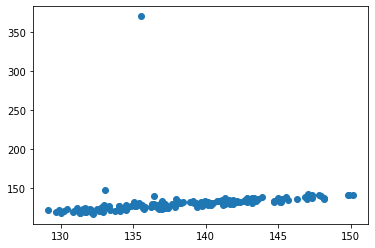

In [108]:
plt.scatter(rc_xy[0], rc_xy[1])

linregress(rc_xy)

In [109]:
# df.pivot(index='case', columns='method', values='rsquared')
df[df['case'] == c]

case  rsquared     slope  \
91  (chicago, control_concrete_inf, True)  0.965506  0.665222   
92  (chicago, control_concrete_inf, True)  0.919099  1.127183   
93  (chicago, control_concrete_inf, True)  0.049738  0.879148   
94  (chicago, control_concrete_inf, True)  0.986522  0.948119   
95  (chicago, control_concrete_inf, True)  0.947567  0.852702   
96  (chicago, control_concrete_inf, True)  0.973426  0.993789   
97  (chicago, control_concrete_inf, True)  0.973551  0.998609   

                       method       mape  
91          Energy\nSignature  62.308574  
92                 RC Order 1  10.132995  
93                 RC Order 2  10.137041  
94                        CNN   0.587966  
95                        RNN   1.120237  
96  Optimization\nCalibration   0.651946  
97      Bayesian\nCalibration   0.650196

In [110]:
rc_df[['names', 'probt']]

names  \
0    ['Ti0' 'Te0' 'Aw' 'Ce' 'Ci' 'e11' 'p11' 'p22' ...   
1    ['Ti0' 'Te0' 'Aw' 'Ce' 'Ci' 'e11' 'p11' 'p22' ...   
3    ['Ti0' 'Te0' 'Aw' 'Ce' 'Ci' 'e11' 'p11' 'p22' ...   
4    ['Ti0' 'Te0' 'Aw' 'Ce' 'Ci' 'e11' 'p11' 'p22' ...   
6    ['Ti0' 'Te0' 'Aw' 'Ce' 'Ci' 'e11' 'p11' 'p22' ...   
..                                                 ...   
174  ['Ti0' 'Te0' 'Aw' 'Ce' 'Ci' 'e11' 'p11' 'p22' ...   
175  ['Ti0' 'Te0' 'Aw' 'Ce' 'Ci' 'e11' 'p11' 'p22' ...   
176  ['Ti0' 'Te0' 'Aw' 'Ce' 'Ci' 'e11' 'p11' 'p22' ...   
177  ['Ti0' 'Te0' 'Aw' 'Ce' 'Ci' 'e11' 'p11' 'p22' ...   
178  ['Ti0' 'Te0' 'Aw' 'Ce' 'Ci' 'e11' 'p11' 'p22' ...   

                                                 probt  
0    [0.00000000e+00 0.00000000e+00 1.99840144e-15 ...  
1    [0.00000000e+00 0.00000000e+00 0.00000000e+00 ...  
3    [0.00000000e+00 0.00000000e+00 1.86517468e-14 ...  
4    [0.00000000e+00 0.00000000e+00 0.00000000e+00 ...  
6    [0.00000000e+00 0.00000000e+00 6.27782271e-11 ...  
..                                                 ...  
174  [0.00000000e+00 0.00000000e+00 6.80087098e-11 ...  
175  [0.00000000e+00 0.00000000e+00 5.68885596e-08 ...  
176  [0.00000000e+00 0.00000000e+00 3.75383946e-10 ...  
177  [0.00000000e+00 0.00000000e+00 1.43307588e-12 ...  
178  [0.00000000e+00 0.00000000e+00 7.10542736e-13 ...  

[157 rows x 2 columns]

In [111]:
df = pd.DataFrame(rows) 
df

case  rsquared     slope  \
0    (victoria, control_concrete, False)  0.986806  0.933083   
1    (victoria, control_concrete, False)  0.981036  1.099957   
2    (victoria, control_concrete, False)  0.730199  1.079133   
3    (victoria, control_concrete, False)  0.992540  0.936399   
4    (victoria, control_concrete, False)  0.988836  0.980724   
..                                   ...       ...       ...   
107    (chicago, control_wood_inf, True)  0.836121  1.292217   
108    (chicago, control_wood_inf, True)  0.987913  0.953471   
109    (chicago, control_wood_inf, True)  0.901975  0.877786   
110    (chicago, control_wood_inf, True)  0.961887  0.995586   
111    (chicago, control_wood_inf, True)  0.961402  1.001734   

                        method      mape  
0            Energy\nSignature  0.459127  
1                   RC Order 1  0.302382  
2                   RC Order 2  0.312237  
3                          CNN  0.017050  
4                          RNN  0.043856  
..                         ...       ...  
107                 RC Order 2  0.021476  
108                        CNN  0.003971  
109                        RNN  0.010574  
110  Optimization\nCalibration  0.016832  
111      Bayesian\nCalibration  0.016989  

[112 rows x 5 columns]

# Linear Regression Descriptive Stats

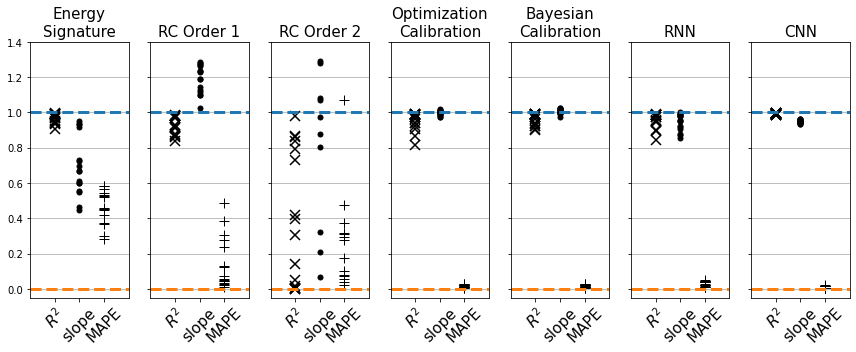

In [112]:
def plot_rsquare_slope(df1, method, ax, show_xlabels=False):
    df = df1[df1['method'] == method]
    ms = ['o', 'v', '^', '<', '>', 's', 'p', 'P', '*', 'h', 'H', 'X', 'D', 'd', '$f$', '$s$']
    cs = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray',
          'tab:olive', 'tab:cyan', 'black', 'lightcoral', 'indigo', 'gold', 'mediumslateblue', 'greenyellow']

    for r, s, e, m, c in zip(df['rsquared'], df['slope'], df['mape'], ms, cs):
#         ax.plot([0.25], r, marker='.', markersize=20, color=c, markeredgewidth=1.5, markeredgecolor='black')
#         if s < 2 and s > -8:
#             ax.plot([0.5], s, marker='.', markersize=20, color=c, markeredgewidth=1, markeredgecolor='black')
#         ax.plot([0.75], e, marker='.', markersize=20, color=c, markeredgewidth=1, markeredgecolor='black')
        ax.plot([0.25], r, marker='x', markersize=10, color='black', markeredgewidth=1.5, markeredgecolor='black')
        if s < 2 and s > -8:
            ax.plot([0.5], s, marker='.', markersize=10, color='black', markeredgewidth=1, markeredgecolor='black')
        ax.plot([0.75], e, marker='+', markersize=10, color='black', markeredgewidth=1, markeredgecolor='black')

    x1 = [0.25, 0.5 ,0.75]
    squad = [r'$R^2$','slope', 'MAPE']

#     ax.set_yticklabels(squad,fontsize=0);
    if show_xlabels:
        ax.set_xticks(x1)
        ax.set_xticklabels(squad, minor=False, rotation=45, fontsize=15);
    else:
        ax.set_xticklabels(squad, minor=False, rotation=45, fontsize=0);
    ax.yaxis.grid()
    ax.set_xlim(0,1)
    ax.set_ylim(-0.05, 1.4)
    ax.axhline(0, linestyle='--', linewidth=3, color='tab:orange', label=r'Perfect $R^2$ and slope')
    ax.axhline(1, linestyle='--', linewidth=3, label=r'Perfect MAPE')
    if method in ['Surrogate \n Calibration', 'Bayesian \n Calibration']:
        ax.set_title(method, fontsize=12)
    else:
        ax.set_title(method, fontsize=15)

# fig, axes = plt.subplots(2, 4, figsize=(10,10), sharey=True, sharex=True)

# plot_rsquare_slope(df, 'Balance\nPoint', axes[0,0])
# plot_rsquare_slope(df, 'CTSM\nOrder 1', axes[0,1])
# plot_rsquare_slope(df, 'CTSM\nOrder 2', axes[0,2])

# axes[0,3].legend(('test'))
# plot_rsquare_slope(df, 'GA\nCalibration', axes[1,0], True)
# plot_rsquare_slope(df, 'Bayesian\nCalibration', axes[1,1], True)
# plot_rsquare_slope(df, 'RNN', axes[1,2], True)
# plot_rsquare_slope(df, 'CNN', axes[1,3], True)

fig, axes = plt.subplots(1, 7, figsize=(12,5), sharey=True, sharex=True)

plot_rsquare_slope(df, 'Energy\nSignature', axes[0], True)
plot_rsquare_slope(df, 'RC Order 1', axes[1], True)
plot_rsquare_slope(df, 'RC Order 2', axes[2], True)

plot_rsquare_slope(df, 'Optimization\nCalibration', axes[3], True)
plot_rsquare_slope(df, 'Bayesian\nCalibration', axes[4], True)
plot_rsquare_slope(df, 'RNN', axes[5], True)
plot_rsquare_slope(df, 'CNN', axes[6], True)

# axes[6].legend(loc='lower left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.savefig('plots/main.png')


# Color Map

Not very happy with this result .. it doesn't tell us much

In [113]:
import matplotlib as mpl
from matplotlib import gridspec


In [114]:
norm = mpl.colors.Normalize(vmin=-1.,vmax=1.)


In [115]:
order = [
   'Energy\nSignature',
    'RC Order 1',
    'RC Order 2',
    'Optimization\nCalibration', 
    'Bayesian\nCalibration', 
    'RNN', 
    'CNN' 
]

In [116]:
df[df['case'] == c]

case  rsquared     slope  \
91  (chicago, control_concrete_inf, True)  0.965506  0.665222   
92  (chicago, control_concrete_inf, True)  0.919099  1.127183   
93  (chicago, control_concrete_inf, True)  0.049738  0.879148   
94  (chicago, control_concrete_inf, True)  0.986522  0.948119   
95  (chicago, control_concrete_inf, True)  0.947567  0.852702   
96  (chicago, control_concrete_inf, True)  0.973426  0.993789   
97  (chicago, control_concrete_inf, True)  0.973551  0.998609   

                       method      mape  
91          Energy\nSignature  0.451330  
92                 RC Order 1  0.073634  
93                 RC Order 2  0.073791  
94                        CNN  0.004078  
95                        RNN  0.007931  
96  Optimization\nCalibration  0.013592  
97      Bayesian\nCalibration  0.013542

In [117]:
df.pivot(index='case', columns='method', values='rsquared')

method                                   Bayesian\nCalibration       CNN  \
case                                                                       
(chicago, control_concrete, False)                    0.984083  0.993769   
(chicago, control_concrete, True)                     0.936564  0.990530   
(chicago, control_concrete_inf, False)                0.989593  0.993828   
(chicago, control_concrete_inf, True)                 0.973551  0.986522   
(chicago, control_wood, False)                        0.990571  0.994709   
(chicago, control_wood, True)                         0.899747  0.991009   
(chicago, control_wood_inf, False)                    0.984921  0.994949   
(chicago, control_wood_inf, True)                     0.961402  0.987913   
(victoria, control_concrete, False)                   0.989188  0.992540   
(victoria, control_concrete, True)                    0.907769  0.986251   
(victoria, control_concrete_inf, False)               0.990022  0.992149   
(victoria, control_concrete_inf, True)                0.942670  0.988426   
(victoria, control_wood, False)                       0.991415  0.994627   
(victoria, control_wood, True)                        0.920105  0.989611   
(victoria, control_wood_inf, False)                   0.986254  0.994990   
(victoria, control_wood_inf, True)                    0.922203  0.987607   

method                                   Energy\nSignature  \
case                                                         
(chicago, control_concrete, False)                0.994443   
(chicago, control_concrete, True)                 0.973004   
(chicago, control_concrete_inf, False)            0.989847   
(chicago, control_concrete_inf, True)             0.965506   
(chicago, control_wood, False)                    0.991012   
(chicago, control_wood, True)                     0.978238   
(chicago, control_wood_inf, False)                0.950128   
(chicago, control_wood_inf, True)                 0.942160   
(victoria, control_concrete, False)               0.986806   
(victoria, control_concrete, True)                0.936484   
(victoria, control_concrete_inf, False)           0.992501   
(victoria, control_concrete_inf, True)            0.966227   
(victoria, control_wood, False)                   0.990322   
(victoria, control_wood, True)                    0.938669   
(victoria, control_wood_inf, False)               0.943130   
(victoria, control_wood_inf, True)                0.904204   

method                                   Optimization\nCalibration  \
case                                                                 
(chicago, control_concrete, False)                        0.984088   
(chicago, control_concrete, True)                         0.937508   
(chicago, control_concrete_inf, False)                    0.988508   
(chicago, control_concrete_inf, True)                     0.973426   
(chicago, control_wood, False)                            0.990323   
(chicago, control_wood, True)                             0.868517   
(chicago, control_wood_inf, False)                        0.986365   
(chicago, control_wood_inf, True)                         0.961887   
(victoria, control_concrete, False)                       0.987830   
(victoria, control_concrete, True)                        0.907474   
(victoria, control_concrete_inf, False)                   0.976153   
(victoria, control_concrete_inf, True)                    0.941965   
(victoria, control_wood, False)                           0.989911   
(victoria, control_wood, True)                            0.920056   
(victoria, control_wood_inf, False)                       0.986353   
(victoria, control_wood_inf, True)                        0.817209   

method                                   RC Order 1  RC Order 2       RNN  
case                                                                       
(chicago, control_concrete, False)         0.981026    0.305509  0.983316  
(chicago, control_concret

In [118]:
case_names = [
    'Chicago, Concrete',
    'Chicago, Concrete,\nSchedules',
    'Chicago, Concrete,\nInfiltration',
    'Chicago, Concrete,\nInfiltration, Schedules',
    
    'Chicago, Wood',
    'Chicago, Wood,\nSchedules',
    'Chicago, Wood,\nInfiltration',
    'Chicago, Wood,\nInfiltration, Schedules',
    
    'Victoria, Concrete',
    'Victoria, Concrete,\nSchedules',
    'Victoria, Concrete,\nInfiltration',
    'Victoria, Concrete,\nInfiltration, Schedules',
    
    'Victoria, Wood',
    'Victoria, Wood,\nSchedules',
    'Victoria, Wood,\nInfiltration',
    'Victoria, Wood,\nInfiltration, Schedules',
]

Index([     ('chicago', 'control_concrete', False),
             ('chicago', 'control_concrete', True),
        ('chicago', 'control_concrete_inf', False),
         ('chicago', 'control_concrete_inf', True),
                ('chicago', 'control_wood', False),
                 ('chicago', 'control_wood', True),
            ('chicago', 'control_wood_inf', False),
             ('chicago', 'control_wood_inf', True),
           ('victoria', 'control_concrete', False),
            ('victoria', 'control_concrete', True),
       ('victoria', 'control_concrete_inf', False),
        ('victoria', 'control_concrete_inf', True),
               ('victoria', 'control_wood', False),
                ('victoria', 'control_wood', True),
           ('victoria', 'control_wood_inf', False),
            ('victoria', 'control_wood_inf', True)],
      dtype='object', name='case')


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: UserWarning: Use the colorbar set_ticks() method instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: UserWarning: Use the colorbar set_ticks() method instead.


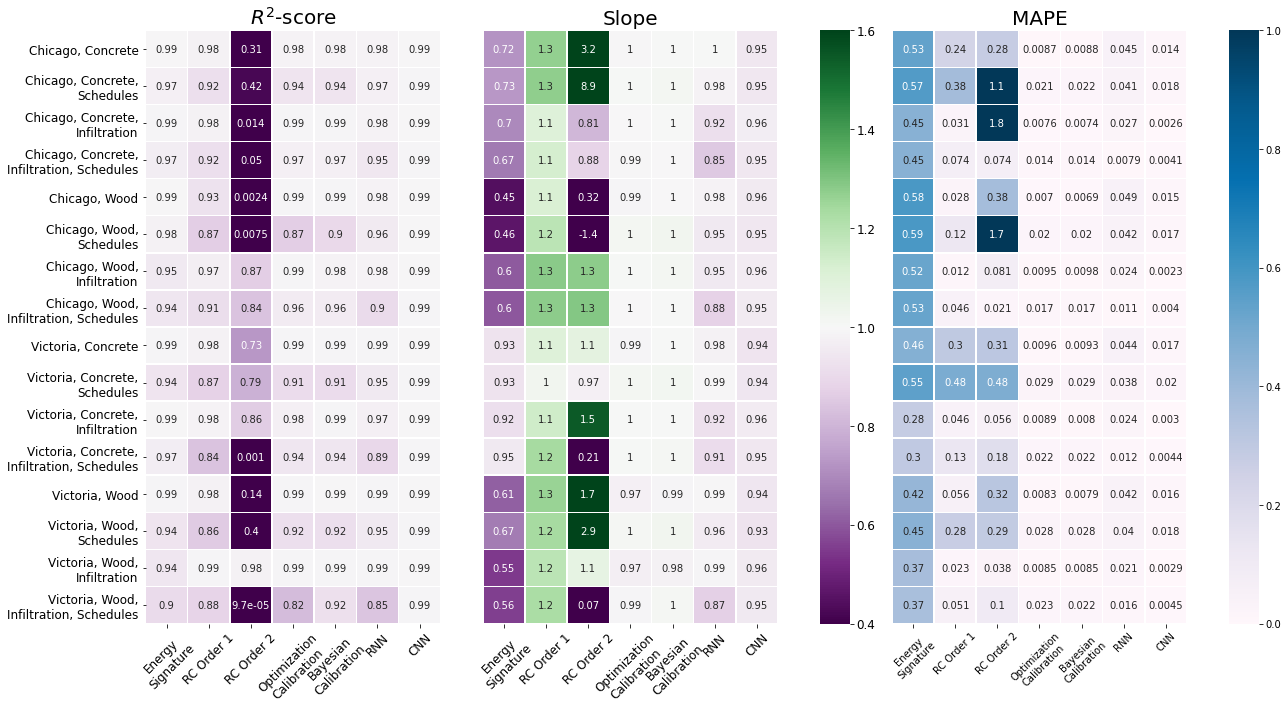

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

In [132]:
# fix, axes = plt.subplots(1, 2, figsize=(10,10))

fig = plt.figure(figsize=(18,10))
spec = gridspec.GridSpec(ncols=5, nrows=1,
                         width_ratios=[5, 5, 0.5 ,5 , 0.5])

ax0=fig.add_subplot(spec[0])
ax1=fig.add_subplot(spec[1])
ax2=fig.add_subplot(spec[2])
ax3=fig.add_subplot(spec[3])
ax4=fig.add_subplot(spec[4])

mape_corr = df.pivot(index='case', columns='method', values='rsquared')
print(mape_corr.index)
mape_corr = mape_corr[order]
mape_corr.index = case_names
sns.heatmap(mape_corr, linewidths=.5, vmin=0.4, vmax=1.6, ax=ax0, annot=True, cbar=False, cmap='PRGn')
# ax0.set_ylabel('Experimental Group', fontsize=15)

# ax2 = fig.add_subplot(122)

mape_corr = df.pivot(index='case', columns='method', values='slope')
mape_corr = mape_corr[order]
# mape_corr = mape_corr.sort_values(by=['RC'])
plt.figure(figsize=(10,10))
sns.heatmap(mape_corr, linewidths=.5, vmin=0.4, vmax=1.6, ax=ax1, annot=True, cbar_ax=ax2, cmap='PRGn')

mape_corr = df.pivot(index='case', columns='method', values='mape')
mape_corr = mape_corr[order]
# mape_corr = mape_corr.sort_values(by=['RC'])
plt.figure(figsize=(10,10))
sns.heatmap(mape_corr, linewidths=.5, vmin=0, vmax=1, ax=ax3, annot=True, cbar_ax=ax4,  cmap='PuBu')


# ax0.set_yticks([])
ax1.set_yticks([])
ax2.set_yticks([])
ax3.set_yticks([])
ax4.set_yticks([])

ax1.set_ylabel('');
ax2.set_ylabel('');
ax3.set_ylabel('');


# ax1.set_yticks([]);
ax0.set_xlabel('');
ax1.set_xlabel('');
ax2.set_xlabel('');
ax3.set_xlabel('');
ax4.set_xlabel('');

ax0.tick_params(axis='x', labelrotation=45)
ax1.tick_params(axis='x', labelrotation=45);
ax2.tick_params(axis='x', labelrotation=45);
ax3.tick_params(axis='x', labelrotation=45);
ax4.tick_params(axis='x', labelrotation=45);


ax0.tick_params(axis='both', which='major', labelsize=12)
ax1.tick_params(axis='both', which='major', labelsize=12)
ax2.tick_params(axis='both', which='major', labelsize=12)


ax0.set_title('$R^2$-score', fontsize=20)
ax1.set_title('Slope', fontsize=20)
ax3.set_title('MAPE', fontsize=20)


box = ax0.get_position()
# box.x0 = box.x0 + 0.4
# box.x1 = box.x1 + 0.05
ax0.set_position(box)

fig.tight_layout()
fig.savefig('colormap_2.png')



# ax0.set_yticks(['t','t','t','t','t','t','t','t','t','t','t','t','t','t','t','t'])

In [120]:
df

case  rsquared     slope  \
0    (victoria, control_concrete, False)  0.986806  0.933083   
1    (victoria, control_concrete, False)  0.981036  1.099957   
2    (victoria, control_concrete, False)  0.730199  1.079133   
3    (victoria, control_concrete, False)  0.992540  0.936399   
4    (victoria, control_concrete, False)  0.988836  0.980724   
..                                   ...       ...       ...   
107    (chicago, control_wood_inf, True)  0.836121  1.292217   
108    (chicago, control_wood_inf, True)  0.987913  0.953471   
109    (chicago, control_wood_inf, True)  0.901975  0.877786   
110    (chicago, control_wood_inf, True)  0.961887  0.995586   
111    (chicago, control_wood_inf, True)  0.961402  1.001734   

                        method      mape  
0            Energy\nSignature  0.459127  
1                   RC Order 1  0.302382  
2                   RC Order 2  0.312237  
3                          CNN  0.017050  
4                          RNN  0.043856  
..                         ...       ...  
107                 RC Order 2  0.021476  
108                        CNN  0.003971  
109                        RNN  0.010574  
110  Optimization\nCalibration  0.016832  
111      Bayesian\nCalibration  0.016989  

[112 rows x 5 columns]

In [121]:
# # fix, axes = plt.subplots(1, 2, figsize=(10,10))

# fig = plt.figure(figsize=(15,10))
# spec = gridspec.GridSpec(ncols=4, nrows=1,
#                          width_ratios=[5,5,4,0.5])

# ax0=fig.add_subplot(spec[0])
# ax1=fig.add_subplot(spec[1])
# ax2=fig.add_subplot(spec[2])

# mape_corr = df.pivot(index='case', columns='method', values='rsquared')
# mape_corr = mape_corr[order]
# mape_corr.index = case_names
# sns.heatmap(mape_corr, linewidths=.5, vmin=0.4, vmax=1.6, ax=ax0, annot=True, cbar=False, cmap='PRGn')
# # ax0.set_ylabel('Experimental Group', fontsize=15)

# # ax2 = fig.add_subplot(122)

# mape_corr = df.pivot(index='case', columns='method', values='slope')
# mape_corr = mape_corr[order]
# # mape_corr = mape_corr.sort_values(by=['RC'])
# plt.figure(figsize=(10,10))
# sns.heatmap(mape_corr, linewidths=.5, vmin=0.4, vmax=1.6, ax=ax1, annot=True, cbar_ax=ax2, cmap='PRGn')

# mape_corr = df.pivot(index='case', columns='method', values='mape')
# mape_corr = mape_corr[order]
# # mape_corr = mape_corr.sort_values(by=['RC'])
# plt.figure(figsize=(10,10))
# sns.heatmap(mape_corr, linewidths=.5, vmin=0.4, vmax=1.6, ax=ax1, annot=True, cbar_ax=ax2, cmap='PRGn')

# ax1.set_yticks([]);
# ax1.set_ylabel('');
# ax0.set_xlabel('');
# ax0.set_ylabel('');
# ax1.set_xlabel('');

# ax0.tick_params(axis='x', labelrotation=45)
# ax1.tick_params(axis='x', labelrotation=45);
# ax0.set_title('$R^2$-score', fontsize=20)
# ax1.set_title('Slope', fontsize=20)

# fig.tight_layout()
# fig.savefig('colormap.png')

# # ax0.set_yticks(['t','t','t','t','t','t','t','t','t','t','t','t','t','t','t','t'])

# Sanity Check Results

In [122]:
df[df['method'] == 'CNN']

case  rsquared     slope method  \
3        (victoria, control_concrete, False)  0.992540  0.936399    CNN   
10        (victoria, control_concrete, True)  0.986251  0.939921    CNN   
17           (victoria, control_wood, False)  0.994627  0.943072    CNN   
24            (victoria, control_wood, True)  0.989611  0.933889    CNN   
31        (chicago, control_concrete, False)  0.993769  0.947719    CNN   
38         (chicago, control_concrete, True)  0.990530  0.945036    CNN   
45            (chicago, control_wood, False)  0.994709  0.955032    CNN   
52             (chicago, control_wood, True)  0.991009  0.947981    CNN   
59   (victoria, control_concrete_inf, False)  0.992149  0.961840    CNN   
66    (victoria, control_concrete_inf, True)  0.988426  0.948432    CNN   
73       (victoria, control_wood_inf, False)  0.994990  0.955879    CNN   
80        (victoria, control_wood_inf, True)  0.987607  0.950715    CNN   
87    (chicago, control_concrete_inf, False)  0.993828  0.962629    CNN   
94     (chicago, control_concrete_inf, True)  0.986522  0.948119    CNN   
101       (chicago, control_wood_inf, False)  0.994949  0.961391    CNN   
108        (chicago, control_wood_inf, True)  0.987913  0.953471    CNN   

         mape  
3    0.017050  
10   0.020052  
17   0.016287  
24   0.018336  
31   0.013797  
38   0.017618  
45   0.015233  
52   0.016863  
59   0.003019  
66   0.004422  
73   0.002936  
80   0.004456  
87   0.002568  
94   0.004078  
101  0.002333  
108  0.003971

In [123]:
cnn0_pth = os.path.join(blackbox_root, cnn0_fname(('chicago', 'control_wood', False)))
cnn0_df  = pd.read_csv(cnn0_pth).dropna()   

In [124]:
plt.scatter(cnn0_df['envelope_hlc'], cnn0_df['envelope_hlc_pred'])
plt.plot(cnn0_df['envelope_hlc'], cnn0_df['envelope_hlc'])

KeyError: 'envelope_hlc'

In [125]:
def linregress_test(xy):
    """ Returns Rsquared and Slope """
    x, y = xy
    X = sm.add_constant(x, has_constant='add')
    model = sm.OLS(y, X).fit()
#     return model.rsquared, model.params[0]
    return model

m = linregress_test((cnn0_df['envelope_hlc'].tolist(), cnn0_df['envelope_hlc_pred'] .tolist()))

KeyError: 'envelope_hlc'

In [126]:
m.params

NameError: name 'm' is not defined

In [127]:
x, y = get_xy(df, 'HLC')

KeyError: 'hlc_tot'

In [128]:
df

case  rsquared     slope  \
0    (victoria, control_concrete, False)  0.986806  0.933083   
1    (victoria, control_concrete, False)  0.981036  1.099957   
2    (victoria, control_concrete, False)  0.730199  1.079133   
3    (victoria, control_concrete, False)  0.992540  0.936399   
4    (victoria, control_concrete, False)  0.988836  0.980724   
..                                   ...       ...       ...   
107    (chicago, control_wood_inf, True)  0.836121  1.292217   
108    (chicago, control_wood_inf, True)  0.987913  0.953471   
109    (chicago, control_wood_inf, True)  0.901975  0.877786   
110    (chicago, control_wood_inf, True)  0.961887  0.995586   
111    (chicago, control_wood_inf, True)  0.961402  1.001734   

                        method      mape  
0            Energy\nSignature  0.459127  
1                   RC Order 1  0.302382  
2                   RC Order 2  0.312237  
3                          CNN  0.017050  
4                          RNN  0.043856  
..                         ...       ...  
107                 RC Order 2  0.021476  
108                        CNN  0.003971  
109                        RNN  0.010574  
110  Optimization\nCalibration  0.016832  
111      Bayesian\nCalibration  0.016989  

[112 rows x 5 columns]

In [129]:
x

NameError: name 'x' is not defined

In [130]:
y

NameError: name 'y' is not defined

In [131]:
plt.scatter(x, y)
plt.plot(x, x)

NameError: name 'x' is not defined

In [45]:
linregress(x, y)

(0.9421604831787536, 0.5987796356171747)

In [42]:
m.params[0]

0.5987796356171747